When I tried to run the Hopf model in the natural space I faced some problems and this is why I decided to build a whole pipeline from scratch. Roughly: first I defined some custom functions. I also used some other custom functions that you can find in the script called "MyFunctions". Sorry for the mess :)

In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure
import seaborn as sns
import myFunctions as fct
from scipy import signal
from scipy.signal import butter
from scipy.signal import filtfilt
from scipy.interpolate import interp2d
from scipy.fft import fft
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid


def butter_lowpass_filter(data, low_cutoff, fs, order):
    normal_cutoff = low_cutoff/nyq 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, high_cutoff, fs, order):
    normal_cutoff = high_cutoff/nyq 
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, low_cutoff, high_cutoff, fs, order):
    normal_cutoff = [low_cutoff/nyq, high_cutoff/nyq]
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='bandpass', analog=False)
    y = filtfilt(b, a, data)
    return y

def lagged_FC(matrix_shape, data, D = 1):
    """
    It calculates a laggedFC matrix
        matrix shape
        data: used dataset
        D: 0 if is bidimensional array (12x12); 1 if it is tridimensional array (1x12x12)
    """
    if D == 1:
        FCt = np.zeros((data.shape[0], matrix_shape, matrix_shape))
        for k in range(data.shape[0]):
            for i in range(matrix_shape):
                for j in range(matrix_shape):
                    FCt[k][i][j] = np.corrcoef(data[k, i, :-1], data[k, j, 1:])[0,1]
    if D == 0:
        FCt = np.zeros((matrix_shape, matrix_shape))
        for i in range(matrix_shape):
            for j in range(matrix_shape):
               FCt[i][j] = np.corrcoef(data[i, :-1], data[j, 1:])[0,1] 
    return FCt


def FuC(matrix_shape, data):
    """
    It calculates a FC matrix
        matrix shape
        data: used dataset
    """
    FCt = np.zeros((matrix_shape, matrix_shape))
    for i in range(matrix_shape):
        for j in range(matrix_shape):
            FCt[i][j] = np.corrcoef(data[i, :], data[j, :])[0,1]
    return FCt

def update(EfC, Femp, Fsim, Femptau, Fsimtau, E=1):
    """
    This calculates the distance from the simulated and the empirical FC, and multiplies the EC to update the EC:
    
        EfC: Effective Connectivity
        Femp: empirical FC
        Fsim: simulated FC
        Femptau: shifted empirical FC
        Fsimtau: shifted simulated FC
    """
    x = EfC + E*(Femp - Fsim + Femptau - Fsimtau)
    return x

def subsimulate(simulations, dimensions, patient, d=300, g=0.01, bp = 0):
    """
    This function is a mess, again sorry. Basically it is a function that simulates x times oscillatory activity with the Hopf model
    then it calculates the simulated FC and the shifted simulated FC for each of the x times and averages them, giving two final FC
    matrices (one shifted) that are taken as each step as the final FCs
    """
    valuesFC = []
    valuesFCtau = []
    a = 0
    while a <= simulations:
        XX0, tt0 = simulate(patient, hopf_model, duration=d, dt=0.1, G=g, a=bp)
        FC = FuC(dimensions, XX0)
        FCtau = lagged_FC(dimensions, XX0, D = 0)
        valuesFC.append(FC)
        valuesFCtau.append(FCtau)
        a += 1
    FCs = np.array(valuesFC)
    FCstau = np.array(valuesFCtau)
    FtoRtransformedFC = np.zeros((simulations, dimensions, dimensions))
    for k in range(0, simulations):
        for i in range(0, dimensions):
            for j in range(0, dimensions):
                FtoRtransformedFC[k, i,j] = np.tanh(FCs[k, i, j])
    FtoRtransformedFCtau = np.zeros((simulations, dimensions, dimensions))
    for k in range(0, simulations):
        for i in range(0, dimensions):
            for j in range(0, dimensions):
                FtoRtransformedFCtau[k, i,j] = np.tanh(FCstau[k, i, j])
    x = fct.average_FC(FtoRtransformedFC)
    y = fct.average_FC(FtoRtransformedFCtau)
    
    return x, y

def ssim(mat1, mat2, window_size=11, sigma=1.5, L=1.0):
    """
    Calculate the structure similarity index (SSIM) between two matrices.
    
    Args:
    - mat1 (np.ndarray): The first matrix to compare.
    - mat2 (np.ndarray): The second matrix to compare.
    - window_size (int): The size of the sliding window used to calculate the SSIM. Default is 11.
    - sigma (float): The standard deviation used in the Gaussian filter applied to the matrices. Default is 1.5.
    - L (float): The dynamic range of the matrices. Default is 1.0.
    
    Returns:
    - ssim (float): The SSIM between the two matrices.
    """
    # Convert matrices to float and flatten them
    mat1 = np.float64(mat1)
    mat2 = np.float64(mat2)
    
    # Calculate the mean, variance, and covariance of the matrices
    mu1 = signal.convolve2d(mat1, np.ones((window_size, window_size)), mode='valid') / (window_size ** 2)
    mu2 = signal.convolve2d(mat2, np.ones((window_size, window_size)), mode='valid') / (window_size ** 2)
    sigma1 = np.sqrt(signal.convolve2d(mat1 ** 2, np.ones((window_size, window_size)), mode='valid') / (window_size ** 2) - mu1 ** 2)
    sigma2 = np.sqrt(signal.convolve2d(mat2 ** 2, np.ones((window_size, window_size)), mode='valid') / (window_size ** 2) - mu2 ** 2)
    sigma12 = signal.convolve2d(mat1 * mat2, np.ones((window_size, window_size)), mode='valid') / (window_size ** 2) - mu1 * mu2
    
    # Calculate the SSIM
    c1 = (L * 0.01) ** 2
    c2 = (L * 0.03) ** 2
    numerator = (2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)
    denominator = (mu1 ** 2 + mu2 ** 2 + c1) * (sigma1 ** 2 + sigma2 ** 2 + c2)
    ssim = np.mean(numerator / denominator)
    
    return ssim

Import data and detrend it

In [13]:
all_data = fct.get_fMRI("C:/Users/javie/Desktop/Trabajo/Master/TFM/Data_analysis/ucla_controls_dbs80.mat", "subject")
from scipy.signal import detrend
data = all_data[1,:,:]
detrended_data = np.zeros((80, 152))
for i in range(0, 80):
    detrended_data[i,:] = detrend(data[i, :])

Filter checking using the custom functions. For visualization purposes to check everything was correct I used all the filters, but only the bandpass filter is needed.

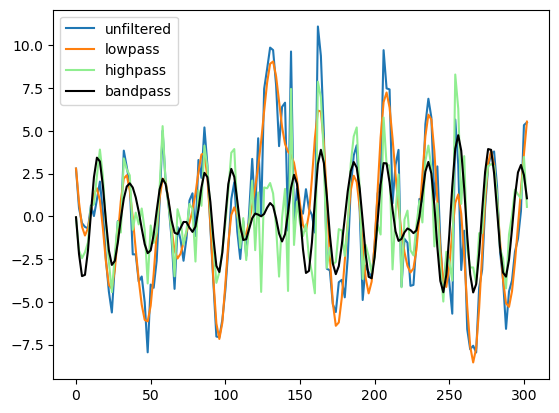

In [15]:
TR = 2
dt = TR

T = 304.0         # Sample Period
fs = 0.5       # sample rate, Hz
low_cutoff = 0.04
high_cutoff = 0.07
nyq = 0.5 * fs  # Nyquist Frequency
order = 9      # sin wave can be approx represented as quadratic
n = int(T * fs)# total number of samples

x = butter_bandpass_filter(detrended_data[1,:], low_cutoff, high_cutoff, fs, order)
y = butter_lowpass_filter(detrended_data[1,:], high_cutoff, fs, order)
z = butter_highpass_filter(detrended_data[1,:], low_cutoff, fs, order)
time = np.array(range(0, 152*TR, 2))
plt.figure(2)
plt.plot(time, detrended_data[1,:], label = 'unfiltered')
plt.plot(time, y, label = 'lowpass')
plt.plot(time, z, c= 'lightgreen',label = 'highpass')
plt.plot(time, x, c = 'black',label = 'bandpass')
plt.legend()
plt.show()

Filter the data

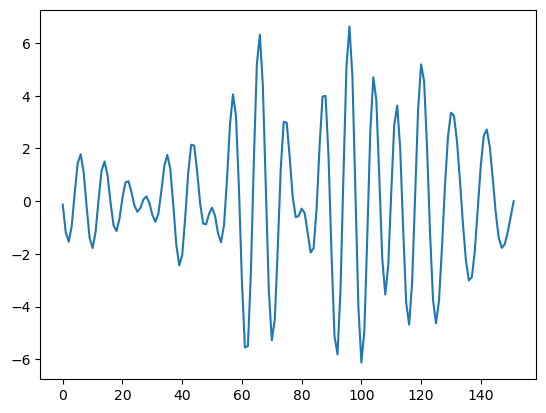

In [16]:
matrix = np.zeros((80,152))
for i in range(0, 80):
    y = butter_bandpass_filter(detrended_data[i,:], low_cutoff, high_cutoff, fs, order)
    matrix[i] = y
    
data_filtered = np.array(matrix)
plt.plot(data_filtered[0,:])
plt.show()

Normalize the filtered data to z-scores

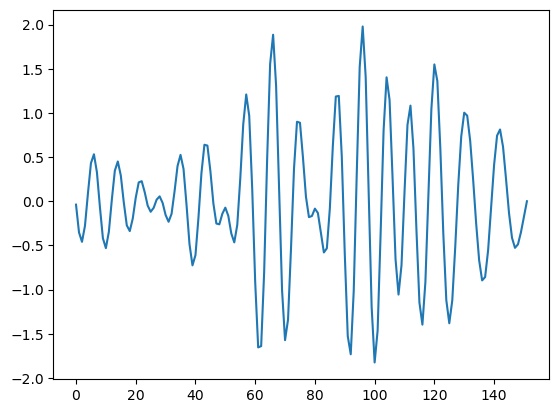

In [17]:
sz_all = data_filtered.shape
all_data_normalized = data_filtered

mean_patient = np.mean(data_filtered)
std_patient = np.std(data_filtered)
for roi_num in range(0, sz_all[0]):
    all_data_normalized[roi_num][:] = (data_filtered[roi_num][:] - mean_patient)/std_patient

if np.round(all_data_normalized.mean(), 5) != 0:
    print(np.round(all_data_normalized.mean(), 5))
    print(all_data_normalized.std())

plt.plot(all_data_normalized[0, :])
plt.show()

Calculate and show a FC matrix

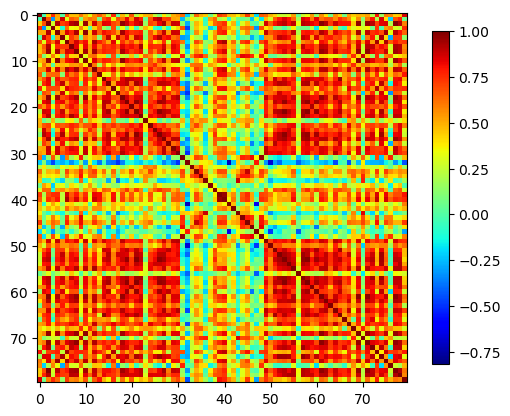

In [7]:
FCemp = FuC(80, all_data_normalized)
FCemptau = lagged_FC(80, all_data_normalized, D=0)
plt.imshow(FCemp, interpolation="nearest", cmap="jet", vmax=1, vmin=np.min(FCemptau))
plt.colorbar(shrink = 0.9)

Show a SC matrix and assign it as the variable EC

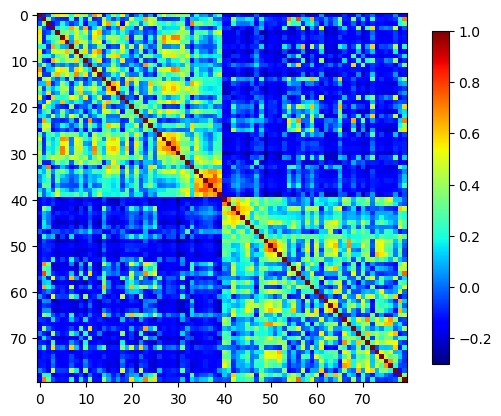

In [8]:
SC_dbs80HARDI = fct.import_mat('SC_dbs80HARDIFULL (2).mat', 'SC_dbs80HARDI')
EC = FuC(80, SC_dbs80HARDI)
#EC = np.zeros((80, 80))
plt.imshow(EC, interpolation="nearest", cmap="jet", vmax=np.max(EC), vmin=np.min(EC))
plt.colorbar(shrink = 0.9)

Run the Hopf model:

In [9]:
def hopf_model(eqs, sig, t_rates, J, G, a, X, Y, w_d, tps, t):
    """
    Standard Hopf model with *dim* nodes
    :param eqs: resting state value for each node (matrix of shape (2,dim))
    :param sig: noise intensity for each node (vector of shape (dim,))--Fixed at 0.04--OK
    :param a: bifurcation parameter (vector of shape (dim,) OR just a scalar)--OK
    :param t_rates: timerate (in Hz) for each node (i.e return to equilibrium speed) (vector of shape (dim,)) -- should be between ¿0.04-0.07?
    :param J: connectivity matrix between nodes (shape (dim,dim)) --- transpose?--OK
    :param G: global coupling factor--Initial condition to modify
    :param X, Y: state of the system at time t (vectors of shape (dim,) real and imaginary parts)
    :param w_d: noise matrix (shape (dim, simulation duration))
    :param tps: time vector (shape (simulation duration,))
    :param t: time point
    :return: Returns dX, dY (vectors of shape (dim,)) increment from t to t+dt for the numerical integration
    """
    
    dim = len(eqs)
    xidx = np.arange(0, dim, 1)
    interpolated = interp2d(tps, xidx, w_d)
    w_dt = interpolated(t, xidx)

    dX =(a - ( X - eqs)**2 - (Y - eqs)**2)*(X - eqs) - t_rates*(Y - eqs) + G*(np.matmul(J.transpose(), (X - eqs)) - (sum(J).transpose())*(X - eqs)) + sig * w_dt[:, 0]
    dY = (a - (X-eqs)**2 - (Y-eqs)**2)*(Y-eqs) + t_rates*(X - eqs) + G*(np.matmul(J.transpose(), (Y - eqs)) - (sum(J).transpose())*(Y - eqs)) + sig * w_dt[:, 0]

    return dX, dY


def simulate(patient, model, duration, dt, G=1.0, a=-0.2):
    """
    Numerical integration of the model 'model' for the patient 'patient'
    :param patient: Patient dataclass containing all the patient's information necessary to run the model
    :param model: Choice of model equations (hopf_model, linear_model or stp_model)
    :param duration: duration (in s) of the simulation
    :param dt: timestep for the simulation
    :param G: global coupling factor
    :param a: bifurcation parameter (vector of shape (dim,) OR just a scalar, only if model=hopf_model)
    :return: *dim* simulated timeseries of length *duration/dt* (i.e. *duration* seconds)
    """

    #The following lines are made to calculate the SEF, which I implemented as the time rates = omega (t_rates here)
    
    L = len(patient[0, :])   #length of data
    Ts = 2    #sampling rate                                  
    Fs = 1/Ts #sampling freq                                              
    Fn = Fs/2 #Nyquist Frequency                                          
    Fv = np.linspace(0, 1, int(np.fix(L/2))+1)*Fn   #Frequency Vector
    Iv = np.arange(len(Fv)) #index vector
    Fourier = fft(patient, axis = 1)/L #Fourier Transform (Along Rows Of Matrix)
    Fouriers = np.sum(np.abs(Fourier), axis=0)    #Spectrum
    IntSpectrum =  cumulative_trapezoid(Fouriers[Iv], Fv) #Numeric Integration (change?)
    SEF = interp1d(IntSpectrum, Fv[:-1], kind='linear')(0.95*IntSpectrum[-1])
  
    J = EC
    t_rates = SEF
    sig = np.array([0.04] * 80)
    
    eqs = np.zeros((patient.shape[0])) 
    for i in range(patient.shape[0]):
        eqs[i] = np.mean(patient[i, :])

    dim = len(eqs)

    # Time sampling
    N = int(np.floor(duration / dt))
    time = np.zeros((N, 1))
    for i in range(0, N):
        time[i] = dt * (i - 1)

    # Noise matrix (1/sqrt(dt) if RK4) 
    w_dot = np.random.randn(dim, N)

    if model == hopf_model:
        X = np.zeros((dim, N))
        Y = np.zeros((dim, N))
        X[:, 0] = eqs
        Y[:, 0] = eqs
        for i in range(0, N - 1):
            dX, dY = model(eqs, sig, t_rates, J, G, a, X[:, i], Y[:, i], w_dot, time, time[i])
            X[:, i + 1] = X[:, i] + dt * dX
            Y[:, i + 1] = Y[:, i] + dt * dY
        return X, time


if __name__ == '__main__':
    XX0, tt0 = simulate(all_data_normalized,hopf_model, duration=300, dt=0.1, G=0.01, a=-0.02)
    XX1, tt1 = simulate(all_data_normalized,hopf_model, duration=300, dt=0.1, G=0.005, a=-0.2)
    XX2, tt2 = simulate(all_data_normalized,hopf_model, duration=300, dt=0.1, G=0.005, a=0.2)

C:\Users\javie\AppData\Local\Temp\ipykernel_4128\1521273660.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interpolated = interp2d(tps, xidx, w_d)
C:\Users\javie\AppData\Local\Temp\ipykernel_4128\1521273660.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2

KeyboardInterrupt: 

Now I've just added visualization cells:

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1)
axs.plot(tt0, XX0[3,:], label = 'a=-0.02')
axs.plot(tt1, XX1[0,:], label = 'a=-0.2')
axs.plot(tt2, XX2[3,:], label = 'a=0.2')
handles, labels = axs.get_legend_handles_labels()
axs.legend(labels)
plt.show()

Now I update the first EC (first input was a SC, now I build the real first EC)

In [ ]:
FC = FuC(80, XX2)
FCtau = lagged_FC(80, XX2, D = 0)
plt.imshow(FC, interpolation="nearest", cmap="jet", vmax=1, vmin=-1)
plt.colorbar(shrink = 0.9)
EC = update(EC, FCemp, FC, FCemptau, FCtau, E = 0.1)
print(ssim(FCemp, X, window_size=11, sigma=1.5, L=1.0))

And I try to fit the EC

In [ ]:
b = 1
i = 0
check = []
check.append(ssim(FCemp, FC, window_size=11, sigma=1.5, L=1.0))
dist = []
dist.append(ssim(FCemp, FC, window_size=11, sigma=1.5, L=1.0))
print(dist)
while i <= 20:
    i += 1
    print(f"Iteration {i} running")
    X, Y = subsimulate(10, 80, all_data_normalized, d=300, g=0.01, bp = 0)
    check.append(ssim(FCemp, X, window_size=11, sigma=1.5, L=1.0))
    dist.append(ssim(FCemp, X, window_size=11, sigma=1.5, L=1.0))
    if check[b] > check[b-1]:
        EC = update(EC, FCemp, X, FCemptau, Y, E = 0.1)
        print(f"dist: {dist[-1]} on iteration {i} ")
        b += 1
    else:
        check = check[:-1]
        
plt.plot(dist)

More visualization cells:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

matrix = np.zeros((80, 80))
for i in range(0, 80):
    for j in range(0, 80):
        if i == j:
            matrix[i,j] = 1
        if i < j:
            matrix[i,j] = FC[i, j]
        if i > j:
            matrix[i,j] = FCemp[i,j]
plt.figure(1, figsize = (3.5, 3))
plt.imshow(matrix, interpolation="nearest", cmap="jet", vmax=1, vmin=-1)
plt.colorbar(shrink = 0.9)

In [ ]:
plt.imshow(EC, interpolation="nearest", cmap="jet", vmax=np.max(EC), vmin=np.min(EC))
plt.colorbar(shrink = 0.9)